In [1]:
# CSCB Final Project

# ! pip install scanpy python-igraph leidenalg
# !pip install --upgrade ipywidgets
# !pip install --upgrade session_info
# !pip install scanpy scipy numpy umap-learn leidenalg
# !pip install matplotlib scikit-learn

import scanpy as sc
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# install pybiomart
try:
    from pybiomart import Server
    BIOMART_AVAILABLE = True
except ImportError:
    BIOMART_AVAILABLE = False


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Task 1

In [2]:
def select_control_mask(adata, obs_key: str, control_values):
    """
    Build a boolean mask selecting control (diploid) cells:
      obs_key       – name of a column in adata.obs
      control_values – value or list of values to treat as 'diploid'
    Returns: mask (pd.Series of bool)
    """
    vals = control_values if isinstance(control_values, (list,tuple)) else [control_values]
    return adata.obs[obs_key].isin(vals)


def ensure_gene_coords(adata, gtf_df: pd.DataFrame=None):
    """
    1. If 'chromosome','start','end' are present in adata.var, do nothing.
    2. Else merge with user‑supplied gtf_df.
    3. Else fetch missing via pybiomart (if installed).
    Drops any genes still lacking coords.
    """
    var = adata.var.copy()
    needed = {'chromosome','start','end'} - set(var.columns)
    if not needed:
        return adata

    # try GTF
    if gtf_df is not None:
        merged = var.merge(
            gtf_df[['gene_name','chrom','start','end']],
            left_index=True, right_on='gene_name', how='left'
        ).set_index(var.index)
        for src,dst in [('chrom','chromosome'),('start','start'),('end','end')]:
            adata.var[dst] = merged[src]

    # fetch missing via BioMart
    missing = adata.var['chromosome'].isna()
    if missing.any() and BIOMART_AVAILABLE:
        server = Server()
        ds = server.marts["ENSEMBL_MART_ENSEMBL"].datasets["hsapiens_gene_ensembl"]
        bm = ds.query(
            attributes=['external_gene_name','chromosome_name','start_position','end_position'],
            filters={'external_gene_name': list(adata.var_names[missing])}
        )
        bm = bm.rename(columns={
            'external_gene_name':'gene_name',
            'chromosome_name':'chrom',
            'start_position':'start',
            'end_position':'end'
        })
        merged2 = adata.var.merge(bm, left_index=True, right_on='gene_name', how='left').set_index(var.index)
        for src,dst in [('chrom','chromosome'),('start','start'),('end','end')]:
            adata.var[dst] = merged2[src].fillna(adata.var[dst])

    # drop genes still missing coords
    to_drop = adata.var['chromosome'].isna()
    if to_drop.any():
        adata = adata[:, ~to_drop].copy()

    return adata


################## 新改的，改成log 2 ratio了
def normalize_expr(adata, control_adata, method='log2_ratio'):  # ← default now 'log2_ratio'
    """
    Gene‐specific normalization against diploid control:
      - 'log2_ratio':  log2((X+1)/(μ+1))
    """
    Xc_raw = control_adata.X
    Xc = Xc_raw.toarray() if sp.issparse(Xc_raw) else np.array(Xc_raw)
    mu = Xc.mean(axis=0)

    X_raw = adata.X
    X = X_raw.toarray() if sp.issparse(X_raw) else np.array(X_raw)

    if method == 'log2_ratio':
        return np.log2((X + 1) / (mu + 1))
    else:
        raise ValueError(f"Only 'log2_ratio' is supported. Got: {method}")
#################################### 改动到这里结束

def sliding_window_segments(Z, var_df, window=50, gain_thr=0.2, loss_thr=-0.2):
    segments = []
    var = var_df.copy()
    var['gene_idx'] = np.arange(len(var))

    for chrom, sub in var.groupby('chromosome'):
        sub = sub.sort_values('start')
        idxs = sub['gene_idx'].values
        avg  = Z[:, idxs].mean(axis=0)
        mv   = pd.Series(avg).rolling(window, center=True, min_periods=1).mean().values

        state = np.zeros_like(mv, int)
        state[mv>=gain_thr] =  1
        state[mv<=loss_thr] = -1

        prev = state[0]; start_i = 0
        for i, s in enumerate(state[1:], start=1):
            if s != prev:
                if prev!=0:
                    segments.append({
                        'chrom': chrom,
                        'start': int(sub.iloc[start_i]['start']),
                        'end':   int(sub.iloc[i-1]['end']),
                        'type':  'gain' if prev>0 else 'loss'
                    })
                start_i = i; prev = s
        if prev!=0:
            segments.append({
                'chrom': chrom,
                'start': int(sub.iloc[start_i]['start']),
                'end':   int(sub.iloc[len(state)-1]['end']),
                'type':  'gain' if prev>0 else 'loss'
            })

    return segments


class CNAInferer:
    def __init__(self,
                 adata,
                 control_adata,
                 gtf_df: pd.DataFrame=None,
                 window=50,
                 gain_thr=0.2,
                 loss_thr=-0.2,
                 norm_method='log2_ratio'):
        # 1) ensure coords
        self.adata = ensure_gene_coords(adata.copy(), gtf_df)
        # 2) align control
        self.control = control_adata[:, self.adata.var_names].copy()
        # 3) params
        self.window      = window
        self.gain_thr    = gain_thr
        self.loss_thr    = loss_thr
        self.norm_method = norm_method

    import numpy as np
    import gc

    def infer(self):
        # Normalize expression (row-wise normalization preferred)
        Z = normalize_expr(self.adata, self.control, method=self.norm_method)

        # Convert to float32 for memory savings
        if Z.dtype != np.float32:
            Z = Z.astype(np.float32, copy=False)

        # Segment genome (runs only once)
        segs = sliding_window_segments(
            Z,
            self.adata.var[['chromosome', 'start', 'end']],
            window=self.window,
            gain_thr=self.gain_thr,
            loss_thr=self.loss_thr
        )
        self.adata.uns['cna_segments'] = segs

        # Precompute segment-gene indices only once
        chrom = self.adata.var['chromosome'].to_numpy()
        start = self.adata.var['start'].to_numpy()
        end = self.adata.var['end'].to_numpy()

        segment_gene_indices = []
        for seg in segs:
            mask = (chrom == seg['chrom']) & (start >= seg['start']) & (end <= seg['end'])
            idxs = np.flatnonzero(mask)
            segment_gene_indices.append(idxs)

        # Free variables not needed anymore
        del chrom, start, end
        gc.collect()

        # Write CNA profiles in chunks to avoid high memory usage
        n_cells = Z.shape[0]
        batch_size = 500  # adjust to fit memory constraints
        profile_chunks = []

        for i in range(0, n_cells, batch_size):
            batch_profiles = []
            Z_batch = Z[i:i + batch_size]  # get only current batch

            for ci in range(Z_batch.shape[0]):
                calls = []
                for seg, idxs in zip(segs, segment_gene_indices):
                    subz = Z_batch[ci, idxs]
                    if subz.size and (
                        (seg['type'] == 'gain' and subz.mean() > 0) or
                        (seg['type'] == 'loss' and subz.mean() < 0)
                    ):
                        calls.append(f"{seg['chrom']}:{seg['start']}-{seg['end']}({seg['type']})")
                batch_profiles.append(";".join(calls))

            profile_chunks.extend(batch_profiles)

            # Clean up
            del Z_batch, batch_profiles
            gc.collect()

        # Store the final profile list
        self.adata.obs['cna_profile'] = profile_chunks

        return self.adata



# Replace your old test_pipeline_on_slice with this:

def test_pipeline_on_slice(
    adata,
    obs_key_control: str,
    control_values,
    obs_key_test: str,
    test_values,
    chromosome: str,
    gtf_df: pd.DataFrame = None,
    window: int = 20,
    gain_thr: float = 0.2,
    loss_thr: float = -0.2,
    norm_method: str = 'log2_ratio'
):
    """
    1) Pick control cells via adata.obs[obs_key_control] ∈ control_values
    2) Pick test  cells via adata.obs[obs_key_test]    ∈  test_values
    3) Subset genes on `chromosome`
    4) Run CNAInferer on that slice
    """
    # build masks
    ctrl_mask = adata.obs[obs_key_control].isin(control_values)
    tst_mask  = adata.obs[obs_key_test]   .isin(test_values)

    # subset
    ctrl = adata[ctrl_mask].copy()
    sub  = adata[tst_mask].copy()
    # keep only genes on the desired chromosome
    sub  = sub[:, sub.var['chromosome'] == chromosome].copy()
    ctrl = ctrl[:, sub.var_names].copy()

    # infer
    inferer = CNAInferer(
        adata        = sub,
        control_adata= ctrl,
        gtf_df       = gtf_df,
        window       = window,
        gain_thr     = gain_thr,
        loss_thr     = loss_thr,
        norm_method  = norm_method
    )
    return inferer.infer()


<ipython-input-5-5ab45d17921e>:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


Called CNA segments:

Example per-cell profiles:
                                  simulated_cnvs cna_profile
AAACCCACAGAGTTGG-1   22:19807132-29743868 (CN 0)            
AAACGAAAGACGTCGA-1   22:19807132-29743868 (CN 0)            
AAACGAACACGACGTC-1  X:106533974-112956833 (CN 4)            
AAACGAAGTTATGTCG-1  X:106533974-112956833 (CN 4)            
AAACGCTAGAGGTTTA-1    6:25435484-35035259 (CN 1)            


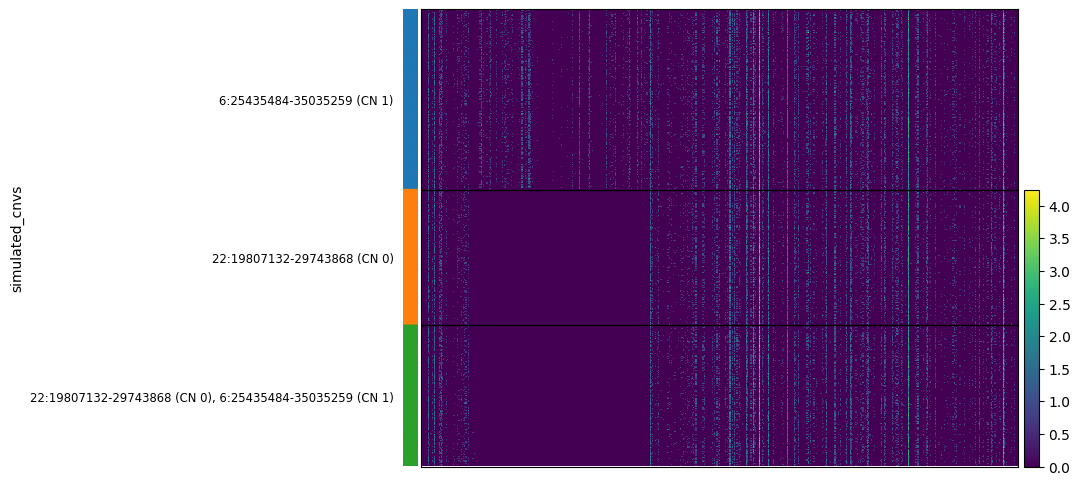

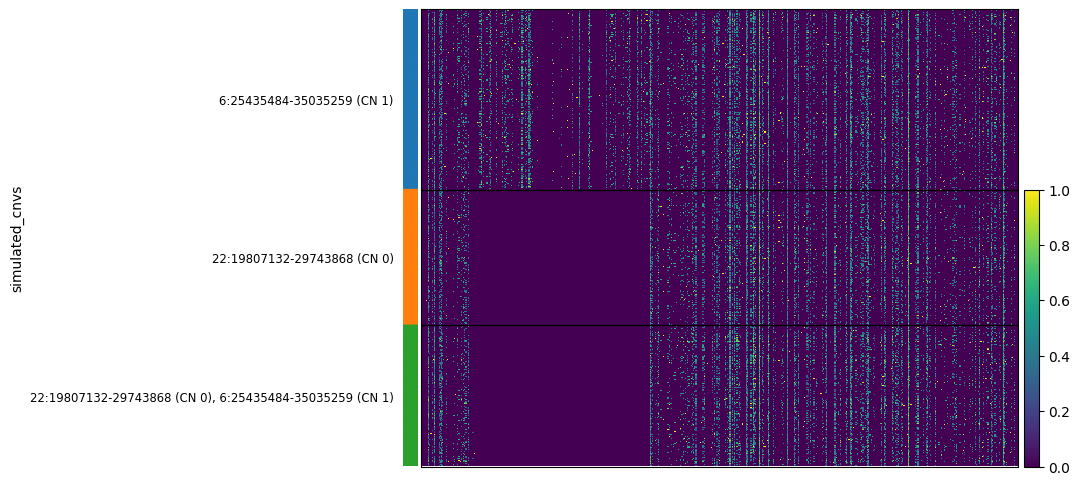

In [ ]:
# Testing

# 1) Load the data

adata = sc.read_h5ad("/content/drive/MyDrive/CSCB/processed_data/PBMC_simulated_cnas_041025.h5ad")

# 2) Define diploid control vs. test (any non‐diploid cell)
ctrl_mask = select_control_mask(adata, 'simulated_cnvs', [''])  # "" == diploid
control    = adata[ctrl_mask].copy()
test       = adata[~ctrl_mask].copy()

# 3) Run inference on all non-diploid cells
inferer = CNAInferer(
    adata         = test,
    control_adata = control,
    gtf_df        = None,      # coords already in this AnnData
    window        = 100,
    gain_thr      =  0.2,
    loss_thr      = -0.2,
    norm_method   = 'log2_ratio'
)
adata2 = inferer.infer()

# 4) Print called segments & a few per-cell profiles
print("Called CNA segments:")
for seg in adata2.uns['cna_segments']:
    print(f"  • Chr{seg['chrom']}:{seg['start']}-{seg['end']} → {seg['type']}")

print("\nExample per-cell profiles:")
print(adata2.obs[['simulated_cnvs','cna_profile']].head())

# subset to CD14 monocytes and Chr 22
adMono = adata2[adata2.obs['cell_type'] == 'CD14 monocyte'].copy()
adChr22 = adMono[:, adMono.var['chromosome'] == '22'].copy()

# Raw counts on left
sc.pl.heatmap(adChr22, adChr22.var_names,
              groupby='simulated_cnvs',
              layer="counts",
              log=True)

# gene-scaled on right makes the CNA footprint more apparent
sc.pl.heatmap(adChr22, adChr22.var_names,
              groupby='simulated_cnvs',
              layer="counts",
              log=True,
              standard_scale='var')


In [ ]:
print(adata.obs)

                                           sample
AAACGAATCATAGGCT-1_Somitoid Day 1  Somitoid Day 1
AAACGAATCGCCATAA-1_Somitoid Day 1  Somitoid Day 1
AAACGCTCACATGACT-1_Somitoid Day 1  Somitoid Day 1
AAACGCTGTCGAGATG-1_Somitoid Day 1  Somitoid Day 1
AAACGCTTCGGAGTGA-1_Somitoid Day 1  Somitoid Day 1
...                                           ...
TTTGTTGCACTGATTG-1_Somitoid Day 5  Somitoid Day 5
TTTGTTGCATCGGATT-1_Somitoid Day 5  Somitoid Day 5
TTTGTTGTCCAAACCA-1_Somitoid Day 5  Somitoid Day 5
TTTGTTGTCCAGTACA-1_Somitoid Day 5  Somitoid Day 5
TTTGTTGTCTAGTACG-1_Somitoid Day 5  Somitoid Day 5

[37432 rows x 1 columns]


# Task 2

In [ ]:
# Task 2A: Access Performance
# ========================
# Install necessary packages
# ========================
# !pip install scanpy python-igraph leidenalg umap-learn scFates matplotlib scikit-learn

# ========================
# Imports
# ========================
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Also import your CNA inference code here
# (Assume you have CNAInferer, select_control_mask, etc. defined above)

# ========================
# Load data
# ========================
# # If your file is on your Google Drive, mount it
# from google.colab import drive
# drive.mount('/content/drive')

# # Example: Adjust this to your file path
# adata_full = sc.read_h5ad("/content/drive/MyDrive/your_folder/PBMC_simulated_cnas_041025.h5ad")

# ========================
# Define evaluation functions
# ========================
def evaluate_cna_call(adata, truth_col='simulated_cnvs', pred_col='cna_profile'):
    y_true = adata.obs[truth_col].apply(lambda x: 0 if x=='' else 1)
    y_pred = adata.obs[pred_col].apply(lambda x: 0 if x=='' else 1)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

def run_cna_evaluation(adata, control, params):
    inferer = CNAInferer(
        adata         = adata.copy(),
        control_adata = control.copy(),
        gtf_df        = None,
        window        = params['window'],
        gain_thr      = params['gain_thr'],
        loss_thr      = params['loss_thr'],
        norm_method   = params['norm_method']
    )
    adata2 = inferer.infer()
    metrics = evaluate_cna_call(adata2)
    return metrics

# ========================
# Prepare control vs test cells
# ========================
ctrl_mask = select_control_mask(adata, 'simulated_cnvs', [''])
control    = adata[ctrl_mask].copy()
test       = adata[~ctrl_mask].copy()

# ========================
# Parameter Grid Search
# ========================
param_grid = [
    {'window': w, 'gain_thr': g, 'loss_thr': -g, 'norm_method': n}
    for w in [20, 50, 100]
    for g in [0.2, 0.4]
    for n in ['zscore', 'log2_ratio']
]

results = []
for params in param_grid:
    print(f"Evaluating {params}")
    metrics = run_cna_evaluation(test, control, params)
    results.append({**params, **metrics})

results_df = pd.DataFrame(results)
print(results_df)

# ========================
# Plot F1 vs Window Size
# ========================
for norm_method in ['zscore', 'log2_ratio']:
    subset = results_df[results_df['norm_method'] == norm_method]
    plt.figure()
    for gthr in subset['gain_thr'].unique():
        subsub = subset[subset['gain_thr'] == gthr]
        plt.plot(subsub['window'], subsub['f1'], marker='o', label=f"gain_thr={gthr}")
    plt.title(f"F1 vs Window Size ({norm_method})")
    plt.xlabel("Window Size")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# ========================
# Explore Impact of Read Depth
# ========================
downsample_rates = [0.9, 0.5, 0.1]
downsample_results = []

for rate in downsample_rates:
    print(f"Downsampling to {rate*100:.0f}% reads")
    adata_ds = adata.copy()
    sc.pp.downsample_counts(adata_ds, counts_per_cell=int(adata_ds.X.sum(1).A1.mean() * rate))

    ctrl_mask = select_control_mask(adata_ds, 'simulated_cnvs', [''])
    control_ds = adata_ds[ctrl_mask].copy()
    test_ds    = adata_ds[~ctrl_mask].copy()

    best_params = {'window': 40, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'}
    metrics = run_cna_evaluation(test_ds, control_ds, best_params)
    downsample_results.append({'read_depth': rate, **metrics})

downsample_df = pd.DataFrame(downsample_results)
print(downsample_df)

# ========================
# Plot Read Depth vs F1
# ========================
plt.figure()
plt.plot(downsample_df['read_depth'], downsample_df['f1'], marker='o')
plt.xlabel("Fraction of Original Read Depth")
plt.ylabel("F1 Score")
plt.title("Effect of Read Depth on CNA Inference")
plt.gca().invert_xaxis()  # higher read depth on left
plt.grid(True)
plt.show()


Evaluating {'window': 20, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'zscore'}


ValueError: Only 'log2_ratio' is supported. Got: zscore



# Task 3

In [3]:
adata3 = sc.read_h5ad("data/num3_adata_filtered.h5ad")

print(adata3.obs.columns)

Index(['timepoint', 'assay', 'batch', 'cell_type'], dtype='object')


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
adata3.obs

,timepoint,assay,batch,cell_type
AACACACAGAACGTCCAAACCAATCCG,D0,scRNA-seq,D0_scRNA-seq,unknown
AACACACAGAACGTCCAACTTCAGTCT,D0,scRNA-seq,D0_scRNA-seq,unknown
AACACACAGAACGTCCAAGTACGGACT,D0,scRNA-seq,D0_scRNA-seq,unknown
AACACACAGAATCCGGTGACGTGTGTT,D0,scRNA-seq,D0_scRNA-seq,unknown
AACACACAGAATCCGGTGCCAATACAG,D0,scRNA-seq,D0_scRNA-seq,unknown
...,...,...,...,...
TGTGGACACTTGAGACAGGTCCTGGTA,D10,Glycosylation-seq,D10_Glycosylation-seq,unknown
TGTGGACACTTGAGACAGTGACAGCTA,D10,Glycosylation-seq,D10_Glycosylation-seq,unknown
TGTGGACACTTGCCGTCAGAACACAGA,D10,Glycosylation-seq,D10_Glycosylation-seq,unknown
TGTGGACACTTGCCGTCAGTAGCACGA,D10,Glycosylation-seq,D10_Glycosylation-seq,unknown


In [6]:
import os
import tarfile
import glob

# 2) Define diploid control vs. test (any non‐diploid cell)
ctrl_mask = select_control_mask(adata3, 'timepoint', ['D0'])
control    = adata3[ctrl_mask].copy()
test       = adata3[~ctrl_mask].copy()

/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
import scanpy as sc
import numpy as np
import anndata as ad
import gc

def prepare_control(adata, time_key='timepoint', ctrl_label='D0', min_genes=200, n_subsample=500):
    ctrl_mask = adata.obs[time_key] == ctrl_label
    control = adata[ctrl_mask].copy()
    
    # Optional: filter low-quality cells
    sc.pp.filter_cells(control, min_genes=min_genes)
    
    # Subsample to reduce size
    if control.n_obs > n_subsample:
        idx = np.random.choice(control.n_obs, n_subsample, replace=False)
        control = control[idx]
    
    return control

def infer_cna_by_timepoint(adata, control, gtf_df=None, time_key='timepoint', exclude=['D0']):
    results = []
    timepoints = sorted(set(adata.obs[time_key]) - set(exclude))

    for tp in timepoints:
        print(f"[INFO] Inferring CNAs for {tp}...")
        tp_mask = adata.obs[time_key] == tp
        test = adata[tp_mask].copy()
        
        inferer = CNAInferer(test, control, gtf_df=gtf_df)
        inferred = inferer.infer()
        results.append(inferred)

    # Combine all inferred AnnData
    combined = ad.concat(results, join='outer', index_unique=None)
    return combined




In [7]:
control = prepare_control(adata3, time_key='timepoint', ctrl_label='D0')
cna_results = infer_cna_by_timepoint(adata3, control, gtf_df=None, time_key='timepoint', exclude=['D0'])


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[INFO] Inferring CNAs for D10...


/tmp/ipykernel_485628/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D2...


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_485628/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D4...


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_485628/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D6...


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_485628/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D8...


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_485628/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
cna_results.obs['cna_profile'].value_counts()

cna_profile
HSCHR2_4_CTG1:1089-50794(loss);HSCHR2_6_CTG1:59578-236573(loss);HSCHR3_2_CTG2_1:1181-164217(loss);HSCHR6_1_CTG5:9444-271782(loss);HSCHR7_1_CTG6:493-119126(loss);HSCHR7_3_CTG6:2415-204593(loss);HSCHR16_2_CTG3_1:60798-87707(loss);HSCHR17_7_CTG4:1320988-1645974(loss);HSCHR21_3_CTG1_1:736-2780(loss);HSCHR22_1_CTG4:59734-259895(loss)                                     40588
HSCHR2_1_CTG1:9880-110463(loss);HSCHR2_4_CTG1:1089-50794(loss);HSCHR2_6_CTG1:59578-236573(loss);HSCHR3_2_CTG2_1:1181-164217(loss);HSCHR6_1_CTG5:9444-271782(loss);HSCHR7_1_CTG6:493-119126(loss);HSCHR7_3_CTG6:2415-204593(loss);HSCHR16_2_CTG3_1:60798-87707(loss);HSCHR17_7_CTG4:1320988-1645974(loss);HSCHR21_3_CTG1_1:736-2780(loss)                                       21067
HSCHR2_4_CTG1:1089-50794(loss);HSCHR2_6_CTG1:59578-236573(loss);HSCHR3_2_CTG2_1:1181-164217(loss);HSCHR6_1_CTG5:9444-271782(loss);HSCHR7_1_CTG6:493-119126(loss);HSCHR7_3_CTG6:2415-204593(loss);HSCHR16_2_CTG3_1:60798-87707(loss);HSCHR17_3_CTG2

In [13]:
num_gain = cna_results.obs['cna_profile'].str.contains('gain').sum()
print(f"Number of items with 'gain': {num_gain}")

Number of items with 'gain': 17810


In [14]:
num_gain = cna_results.obs['cna_profile'].str.contains('loss').sum()
print(f"Number of items with 'loss': {num_gain}")

Number of items with 'loss': 236863


In [11]:
# 3) Run inference on all non-diploid cells
inferer = CNAInferer(
    adata         = test,
    control_adata = control,
    gtf_df        = None,      # coords already in this AnnData
    window        = 20,
    gain_thr      =  0.15,
    loss_thr      = -0.15,
    norm_method   = 'log2_ratio'
)


In [ ]:
adata_2 = inferer.infer()

In [ ]:




# 4) Print called segments & a few per-cell profiles
print("Called CNA segments:")
for seg in adata_2.uns['cna_segments']:
    print(f"  • Chr{seg['chrom']}:{seg['start']}-{seg['end']} → {seg['type']}")

print("\nExample per-cell profiles:")
print(adata_2.obs[['simulated_cnvs','cna_profile']].head())


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_438176/2035403917.py:68: RuntimeWarning: Mean of empty slice.
  mu = Xc.mean(axis=0)
/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


To do list:

- update task 1 to use log2 ratio instead of z score (comment the lines where i have changed)
- task 2: use window of 40 and threshold of +/-0.15
- task 3: run code for dataset 1 and 2